In [210]:
import compare_simulations as cs
import network_conversion as ntc

import polars as pl
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt, colors
import seaborn as sns

In [3]:
%matplotlib inline

In [10]:
metrics_eh = pl.read_parquet("zero_ss_exact_home_sims/metrics.parquet")

In [17]:
metrics_tn = pl.read_csv("zero_sims/met_df.csv").with_columns(pl.selectors.starts_with('hitting_time').cast(pl.Float64))

In [19]:
tests = cs.recompute_comparison_tests(metrics_tn, metrics_eh, rescaling1=0.2)

/home/davidwu/.virtualenvs/monv/lib/python3.10/site-packages/scipy/stats/_survival.py:680: RuntimeWarning: invalid value encountered in scalar divide
  statistic = (n_died_x - sum_exp_deaths_x)/np.sqrt(sum_var)


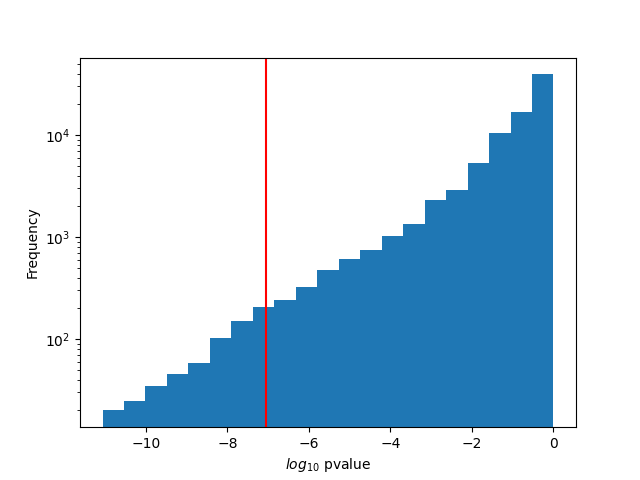

In [217]:
plt.figure('bonf_corrd')
plt.hist([np.log10(x.pvalue) for x in tests.values()], bins=21, log=True)
plt.axvline(np.log10(1e-2 / (338**2)), color='red')
plt.xlabel('$log_{10}$ pvalue')
plt.ylabel('Frequency')
plt.show()

In [218]:
test_mat = np.zeros((338, 338))

for k,v in tests.items():
    test_mat[k] = (v.statistic if np.isfinite(v.statistic) else None)

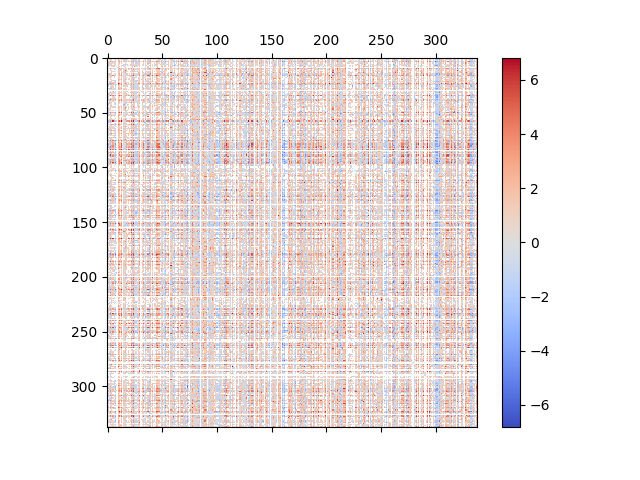

In [160]:
ff = plt.figure('test_stat_val_heatmap')
plt.clf()
plt.matshow(test_mat, fignum=0, cmap='coolwarm', norm=colors.CenteredNorm())
plt.colorbar()
plt.show()

(array([6.0000e+00, 1.7000e+01, 4.1000e+01, 6.4000e+01, 1.5400e+02,
        2.6600e+02, 5.2600e+02, 8.0300e+02, 1.1060e+03, 1.9070e+03,
        2.6620e+03, 4.0530e+03, 7.7910e+03, 5.3640e+03, 8.2260e+03,
        4.3700e+03, 5.8990e+03, 1.2803e+04, 8.0620e+03, 6.5270e+03,
        3.1870e+03, 2.7270e+03, 1.9140e+03, 1.2190e+03, 1.0490e+03,
        8.0900e+02, 5.4700e+02, 3.4300e+02, 2.1600e+02, 1.0000e+02,
        5.5000e+01]),
 array([-6.23776712, -5.81634534, -5.39492357, -4.97350179, -4.55208002,
        -4.13065825, -3.70923647, -3.2878147 , -2.86639292, -2.44497115,
        -2.02354938, -1.6021276 , -1.18070583, -0.75928405, -0.33786228,
         0.08355949,  0.50498127,  0.92640304,  1.34782481,  1.76924659,
         2.19066836,  2.61209014,  3.03351191,  3.45493368,  3.87635546,
         4.29777723,  4.71919901,  5.14062078,  5.56204255,  5.98346433,
         6.4048861 ,  6.82630788]),
 <BarContainer object of 31 artists>)

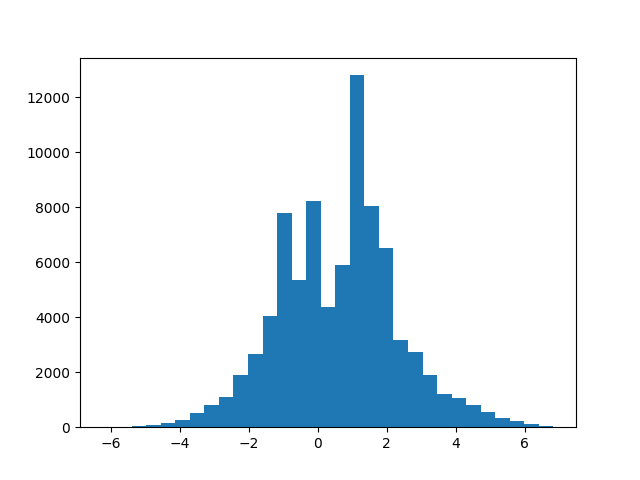

In [137]:
plt.figure('test_mat_hist')
plt.hist(test_mat.flatten(), bins=31)


In [60]:
%matplotlib widget

In [61]:
from mpl_toolkits import mplot3d

In [67]:
test_mat_z = np.array(test_mat)
test_mat_z[np.isnan(test_mat)] = 0

In [104]:
rsum = test_mat_z.sum(axis=1)
csum = test_mat_z.sum(axis=0)

row_sort_order = np.argsort(rsum)
col_sort_order = np.argsort(csum)

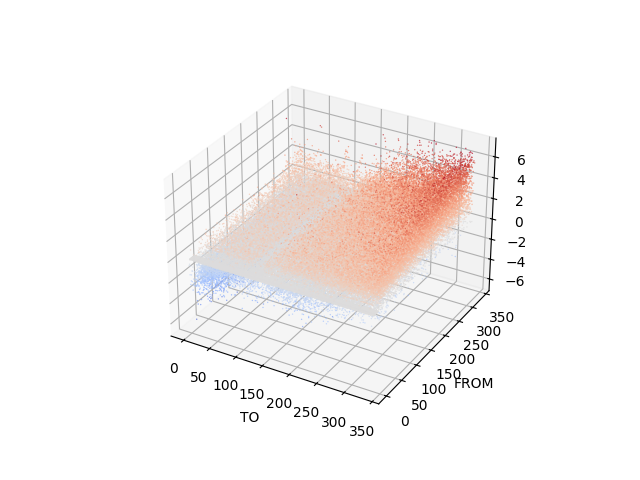

In [183]:
f = plt.figure('3dscat')
plt.clf()
ax = f.add_subplot(projection='3d')

xx, yy = np.meshgrid(np.arange(338), np.arange(338))
zz = test_mat_z[np.ix_(row_sort_order, col_sort_order)]

ax.scatter(xx, yy, zz, s=1, c=zz, cmap='coolwarm', norm=colors.CenteredNorm(), edgecolors='none', alpha=0.7)
ax.set_xlabel('TO')
ax.set_ylabel('FROM')
plt.show()

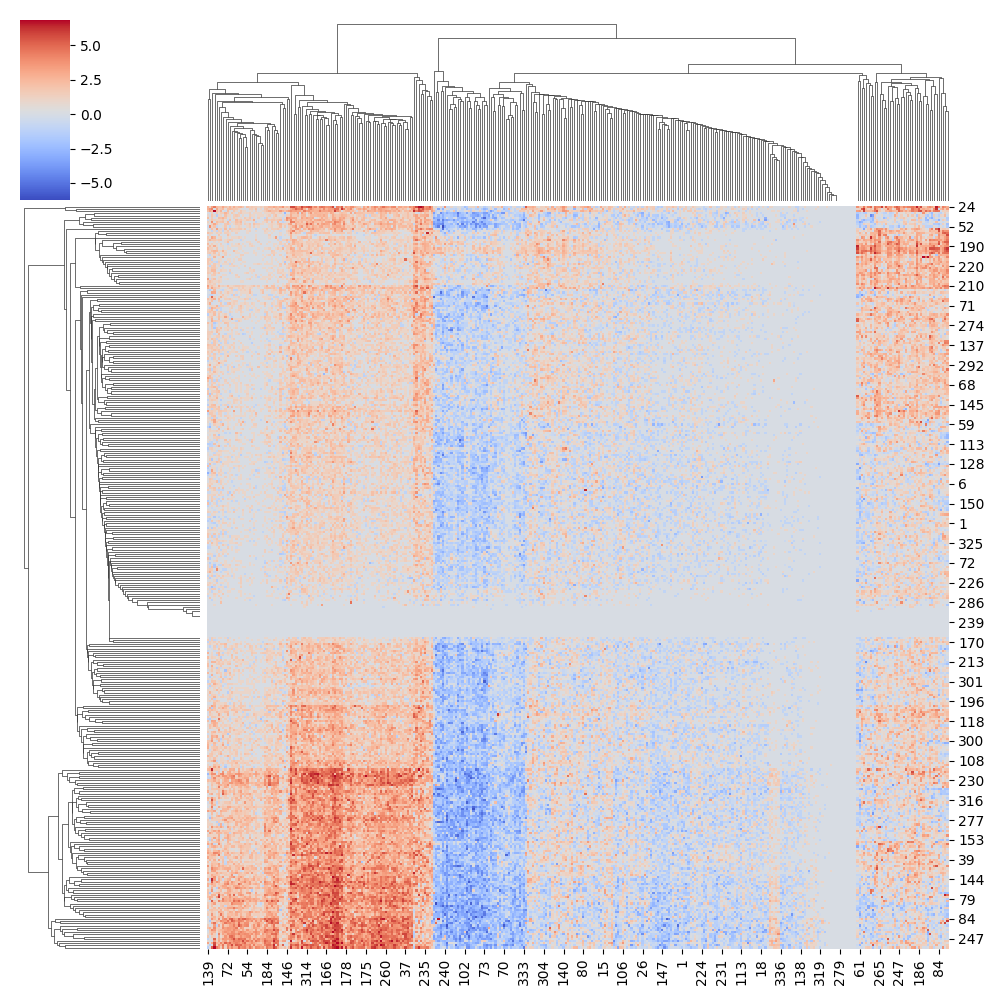

In [211]:
sns.matrix.clustermap(test_mat_z, cmap='coolwarm')

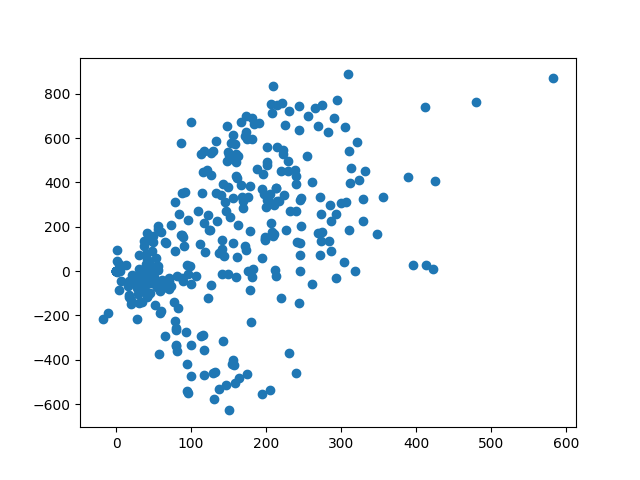

In [139]:
plt.figure('sumvsum')
plt.scatter(rsum, csum)

Text(0.5, 0, 'FROM (Seed Hospital, ordered by statistic sum)')

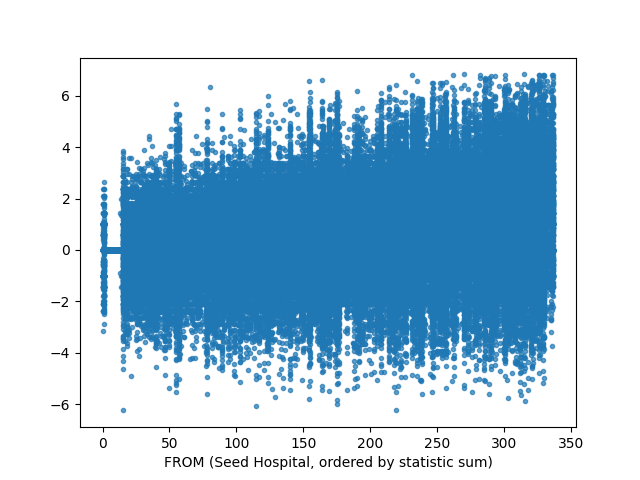

In [140]:
plt.figure('fromflatval')

plt.plot(np.arange(338), test_mat_z[row_sort_order, :], '.', color='C0', alpha=0.7);
plt.xlabel('FROM (Seed Hospital, ordered by statistic sum)')

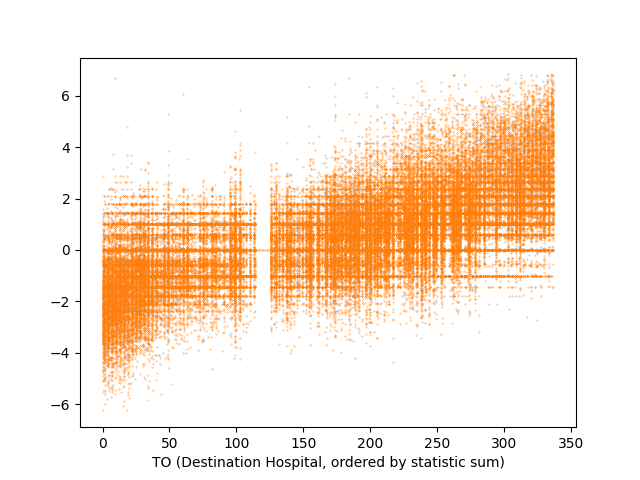

In [159]:
f = plt.figure('toflatval')
plt.clf()
plt.plot(np.arange(338), test_mat[:, col_sort_order].T, '.', color='C1', markersize=0.5, figure=f);
plt.xlabel('TO (Destination Hospital, ordered by statistic sum)')
plt.show()

In [165]:
ordering = ntc.Ordering.from_file("./concordant_networks/size_14.csv")

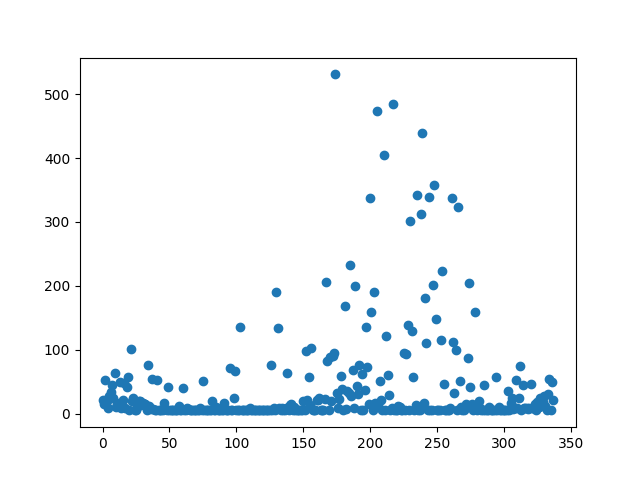

In [169]:
plt.figure('col_order_size')
plt.clf()
plt.plot(ordering.sizes[col_sort_order], marker='o', linestyle='none')
plt.show()

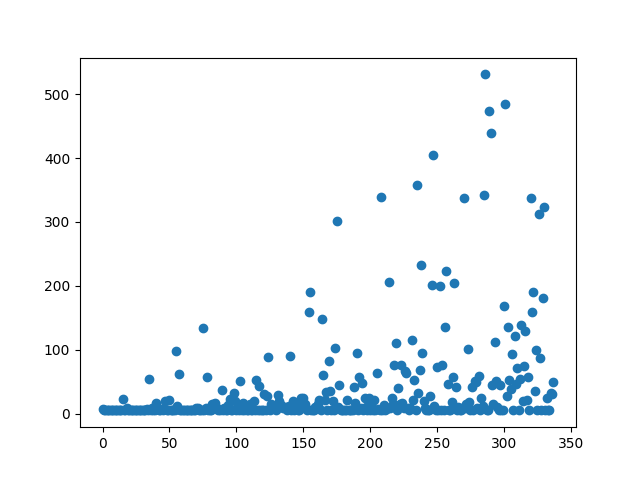

In [212]:
plt.figure('row_order_size')
plt.clf()
plt.plot(ordering.sizes[row_sort_order], marker='o', linestyle='none')
plt.show()

In [191]:
max_stat_idx = np.unravel_index(np.argmax(test_mat_z), test_mat_z.shape)

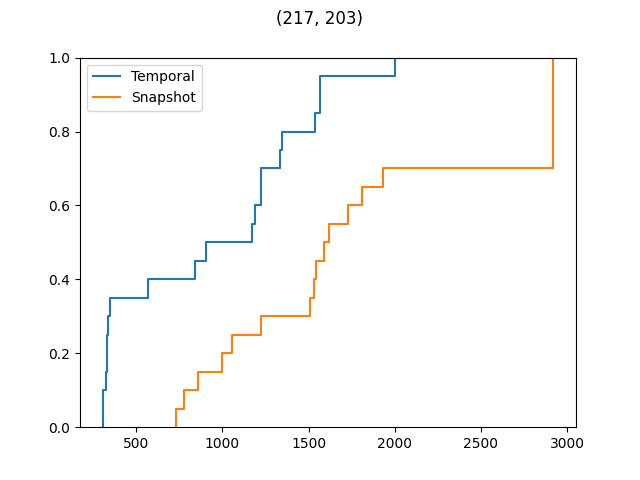

In [204]:
f = plt.figure('ecdf_max_stat')
f.clf()
ax = f.add_subplot()
cs.plot_multiple_ecdf(max_stat_idx, [metrics_tn, metrics_eh], maxt=8*365+1, labels=['Temporal', 'Snapshot'], ax=ax)
ax.legend()
f.suptitle(f"{max_stat_idx}")
plt.show()